In [1]:
import sys
import numpy as np
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from scipy.constants import mu_0, epsilon_0
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps
    from fem_processing import matrices_assembly as assembly
    from fem_pos_processing import graph_results as graph
    print("Modules imports were successful!")
except ModuleNotFoundError as e:
    print(f"Modules were not found: {e}")
except ImportError as e:
    print(f"Error in import: {e}")
    
#run ../setup_project.py

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


## Physics Constants

In [2]:
K0 = 2 * np.pi * 3E8 * np.sqrt(mu_0 * epsilon_0)
WAVELENGTH = 2 * np.pi / K0

# Project 3: Problem 2 (p32)
# 3-noded Linear Triangular Elements, $P_1$

In [3]:
FINITE_ELEMENT = ("Triangle", 1)
BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': None, 'name': 'scatterer'},
            {'tag': 102, 'type': 'BGT', 'value': None, 'name': 'truncated_domain'}]
MATERIAL = [{'tag': 201, 'name': 'free_space',
             'relative_magnetic_permeability': 1, 'relative_electric_permittivity': 1}]

# Define o domínio do problema
R_DOMAIN = 'R4'

# Aplicar as condições de contorno absorventes (ABC)
BGT = ps.apply_bgt_constants(R_DOMAIN)

# Criar geometria coaxial
mesh_data = ps.create_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h=1/20, R=R_DOMAIN, view_mesh=False)

Malha salva em pre_processing/mesh/circular_pec_domain_Triangle1.msh
Model circular_pec (2D)
Info     : 5 geometric entities
Info     : 3 Physical Groups
Info     : 5294 nodes in total
Info     : 10273 2-D elements in total


## Figure 1: Meshed domain 

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p32_circular_pec_scatterer_abc\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


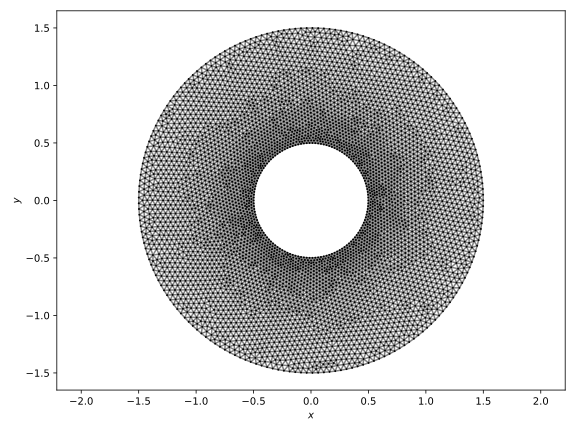

In [4]:
graph.plot_mesh(FINITE_ELEMENT, mesh_data, numbering=False)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

## Figure 2: Boundary conditions map

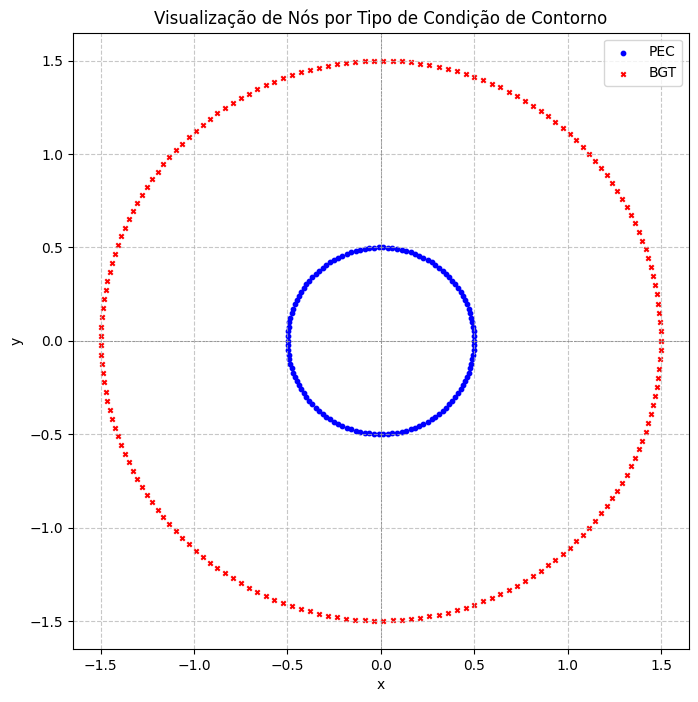

In [5]:
ps.plot_coordinates(mesh_data)

## FEM Solution

In [6]:
Sgr, fgr, Mgr, Pgr, Qgr = assembly.reduced_global_matrices(FINITE_ELEMENT, mesh_data, jw=-(K0**2))
print("Reduced global matrix shape:", Sgr.shape)

Reduced global matrix shape: (5168, 5168)


## _ABC_ Formulation

In [7]:
# Montagem da matriz global
Agr = Sgr - (K0**2) * Mgr + BGT['2']['ALPHA'] * Pgr - BGT['2']['BETA'] * Qgr

# Solução do problema matricial
ezhr = spsolve(Agr.tocsr(), fgr.toarray())
ezh = assembly.global_potentials_solution(mesh_data, ezhr)

## Figure 3: Numerical solution to scattered electric field, $E_z^s$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p32_circular_pec_scatterer_abc\pos_processing\pictures\fem_solution_Triangle1_EntireDomain.svg


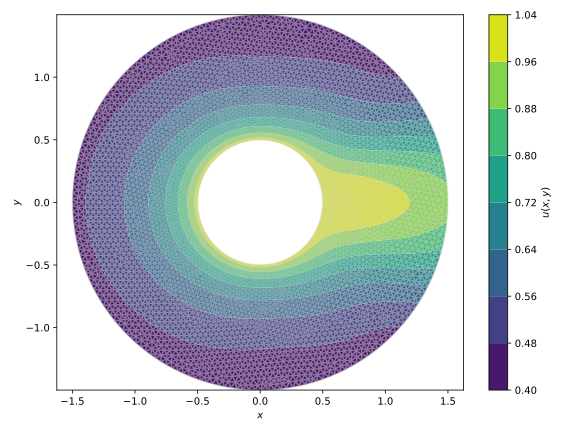

In [8]:
graph.fem_solution(FINITE_ELEMENT, mesh_data, ezh, type='abs')
display(SVG(filename="pos_processing/pictures/fem_solution_Triangle1_EntireDomain.svg"))

## Figure 4: Analytical Solution to Scalar Field Distribution

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p32_circular_pec_scatterer_abc\pos_processing\pictures\analytical_solution.svg


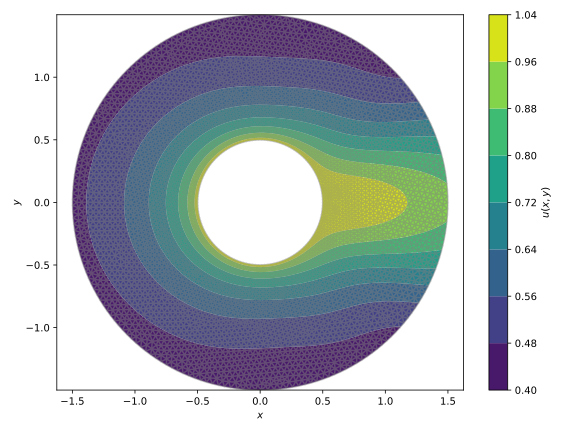

In [9]:
ez = ps.ez_at_omega(FINITE_ELEMENT, mesh_data, type='abs')
display(SVG(filename="pos_processing/pictures/analytical_solution.svg"))

## Error evaluation

In [10]:
u_exact = np.array(list(ez.values()))
u_approx = np.array(list(ezh.values()))
error = ps.calculate_error(u_exact, u_approx)
print(f"Erro entre a solução exata e a solução aproximada: {error:.4f}.")

Erro entre a solução exata e a solução aproximada: 0.0020.


## _BGT Nodes_

In [11]:
bgt_nodes = {key: value 
             for key, value in mesh_data['nodes'].items() if value['bc']['type'] == 'BGT'}

# $E_z$ profile

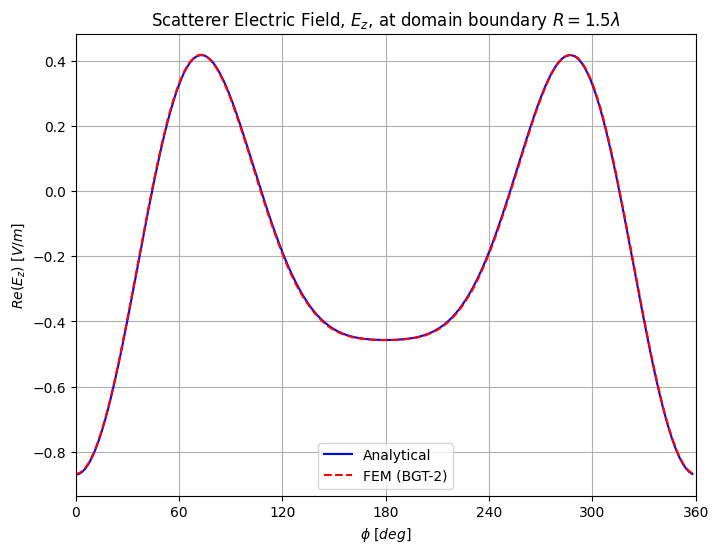

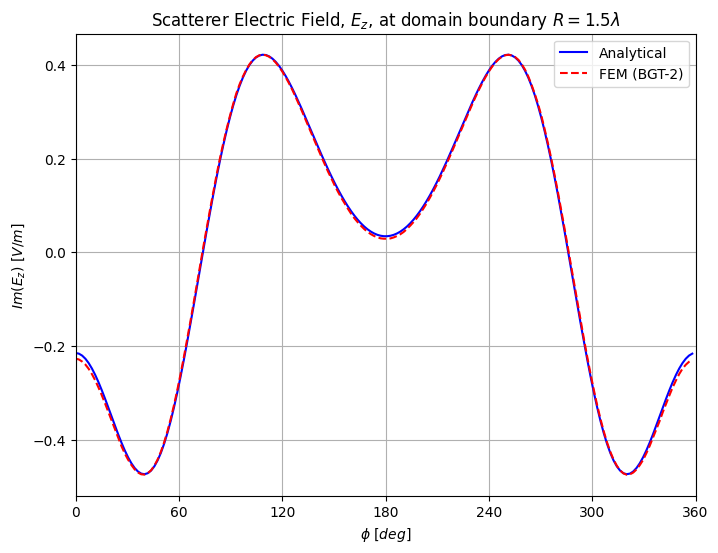

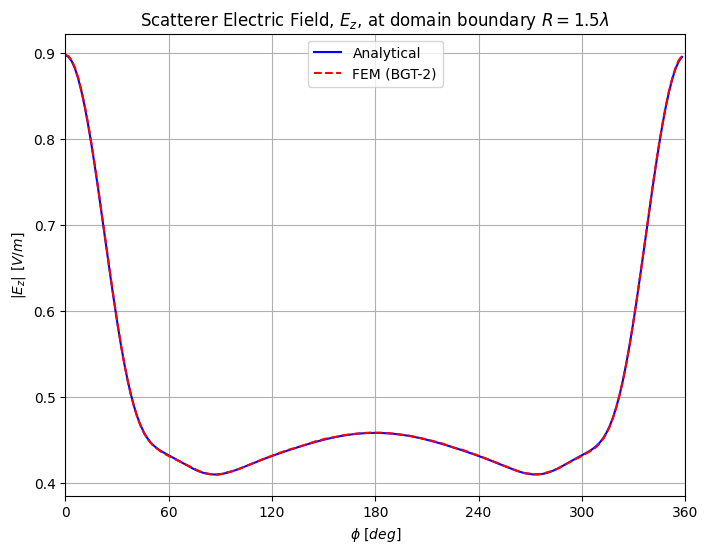

In [12]:
ez_bgt = ps.ez_at_contour(mesh_data, contour='BGT')
ezh_bgt = {key: ezh[key] for key in bgt_nodes.keys()}
ps.plot_ez_profile(ez_bgt, ezh_bgt)

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2024.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.